# Classifying Speech to Emotion using the RAVDESS dataset
###### Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import random
import sys
import glob 
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import lightgbm as lgb
import xgboost as xgb
import optuna
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Functions

## Read in, Extract Features, and Label Data

In [2]:
def extract_feature(file_name):
    """Function Extracts Features from WAV file"""
    X, sample_rate = librosa.load(file_name)
    stft=np.abs(librosa.stft(X))
    result=np.array([])
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    result=np.hstack((result, mfccs))
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, chroma))
    mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    result=np.hstack((result, mel))
    return result

#### Dictionary of Emotions and Function to Append Gender

In [3]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

def gender(g):
    """Returns Gender Label"""
    if int(g[0:2]) % 2 == 0:
        return 'female'
    else:
        return 'male'

### Function to Load and Label Data

In [4]:
def load_data(test_size=0.2):
    """Loads Data from directory containing WAV files."""
    x,y=[],[]
    for file in tqdm(glob.glob("data_w_song\\Actor_*\\*.wav")):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]] + '_' + gender(file_name.split("-")[-1])
        feature=extract_feature(file)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

## Split Data

In [5]:
X_train, X_test, y_train, y_test = load_data()

100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [19:19<00:00,  2.12it/s]


In [6]:
print((X_train.shape[0], X_test.shape[0]))

(1961, 491)


In [7]:
print(f'Features extracted: {X_train.shape[1]}')

Features extracted: 180


### **Hyperparameter tuning should be done before proceeding with scaling

## Scale Data

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Parameter Dictionaries

In [28]:
lgb_params = {'num_leaves': 22, 
              'max_depth': 37, 
              'n_estimators': 12310, 
              'subsample_for_bin': 491645, 
              'min_data_in_leaf': 27, 
              'reg_alpha': 1.744123586157066, 
              'colsample_bytree': 0.6495503686746514, 
              'learning_rate': 0.8581745963346554, 
              'boosting_type': 'dart'}

In [29]:
rf_params = {'criterion': 'entropy', 
             'max_depth': 15, 
             'n_estimators': 22984, 
             'min_samples_leaf': 3, 
             'min_samples_split': 9, 
             'max_leaf_nodes': 239, 
             'random_state': 22}

In [30]:
xgb_params = {'booster': 'gbtree', 
              'lambda': 7.201651687969849e-08, 
              'alpha': 2.2495125443474775e-05, 
              'max_depth': 7, 
              'eta': 9.307925211476325e-06, 
              'gamma': 1.7948741419263195e-05, 
              'grow_policy': 'lossguide'}

In [31]:
dt_params = {'criterion': 'entropy', 
             'max_depth': 35, 
             'min_samples_leaf': 4, 
             'min_samples_split': 23, 
             'max_leaf_nodes': 169}

In [32]:
mlp_params = {'activation': 'relu', 
              'solver': 'lbfgs', 
              'hidden_layer_sizes': 1283, 
              'alpha': 0.3849485717707319, 
              'batch_size': 163, 
              'learning_rate': 'constant',
              'max_iter':1000}

In [33]:
knn_params = {'weights': 'distance', 
              'n_neighbors': 32}

In [34]:
lr_params = {'multi_class':'multinomial',
             'class_weight': None, 
             'solver': 'saga', 
             'max_iter':10000}

### Models and Labels Dictionaries

In [35]:
models = {'dt':DecisionTreeClassifier(**dt_params),
          'rf':RandomForestClassifier(**rf_params), 
          'lgb':lgb.LGBMClassifier(**lgb_params), 
          'xgb':xgb.XGBClassifier(**xgb_params),
          'mlp':MLPClassifier(**mlp_params), 
          'kn':KNeighborsClassifier(**knn_params),  
          'lr':LogisticRegression(**lr_params)}

model_abrv = {'dt':'Decision Tree Classifier', 
              'rf':'Random Forest Classifier', 
              'lgb':'LGBM Classifier', 
              'xgb':'XGB Classifier', 
              'mlp':'MLP Classifier',
              'kn':'K-Nearest Neighbors', 
              'lr':'Logistic Regression', 
              'v':'Voting Classifier: MLP, LGB', 
              'v2':'Voting Classifier 2: KNN, XGB, MLP', 
              'v3':'Voting Classifier 3: XGB, MLP, RF, LR', 
              'v4':'Voting Classifier 4: MLP, XGB'}

Models Dictionary Needs to be Created Before these Parameter Dictionaries

In [36]:
v_params = {'estimators':[('mlp', models['mlp']), 
                          ('lgb', models['lgb'])], 
            'voting':'soft'}

In [37]:
v2_params = {'estimators':[('kn', models['kn']), 
                           ('xgb', models['xgb']), 
                           ('mlp', models['mlp'])], 
             'voting':'soft'}

In [38]:
v3_params = {'estimators':[('xgb', models['xgb']),
                           ('mlp', models['mlp']),
                           ('rf', models['rf']), 
                           ('lr', models['lr'])], 
             'voting':'soft'}

In [39]:
v4_params = {'estimators':[('mlp', models['mlp']), 
                          ('xgb', models['xgb'])], 
            'voting':'soft'}

Add Voting Classifiers to Models Dictionary

In [40]:
models['v'] = VotingClassifier(**v_params)
models['v2'] = VotingClassifier(**v2_params)
models['v3'] = VotingClassifier(**v3_params)
models['v4'] = VotingClassifier(**v4_params)

### Modeling and Statistics Functions

In [41]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, model='clf', save=True):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a seaborn heatmap. 
    Saves confusion matrix file to jpg file."""
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    if save == True:
        plt.savefig('tuned_' + model_abrv[model] + '_confusion_matrix.jpg')
    plt.show()

In [42]:
def model(clf, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, models=models, save=False, print_stat=True, inc_train=False, cv=False):
    """Trains models and outputs score metrics. Takes an identifier, list of models, and split dataset as inputs and has options for saving model, 
    printing confusion matrix and classification report and getting cross-validated 5 fold accuracy."""
    clf_model = models[clf]
    clf_model.fit(X_train, y_train)
    y_pred = clf_model.predict(X_test)
    if print_stat == True:
        clf_report = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).T
        clf_report.to_csv('tuned_' + model_abrv[clf] + '_classification_report.csv')
        print(model_abrv[clf])
        print('\nTest Stats\n', classification_report(y_test,y_pred))
        print_confusion_matrix(confusion_matrix(y_test, y_pred), unique_labels(y_test, y_pred), model=clf)
        if inc_train == True:
            print(model_abrv[clf])
            print('\nTrain Stats\n', classification_report(y_train,clf_model.predict(X_train)))
            print_confusion_matrix(confusion_matrix(y_train, clf_model.predict(X_train)), unique_labels(y_test, y_pred), model=clf)
    if cv == True:
        print(model_abrv[clf] + ' CV Accuracy:',  
              np.mean(cross_val_score(clf_model, X_train, y_train, cv=5, scoring='accuracy')))
    if save == True:
        return clf_model

## Modeling

### CV 5 Fold Accuracy

In [43]:
for key in models.keys():
    model(key, cv=True, print_stat=False)

Decision Tree Classifier CV Accuracy: 0.43085319719293524
Random Forest Classifier CV Accuracy: 0.639350657957607
LGBM Classifier CV Accuracy: 0.6583714034798911
XGB Classifier CV Accuracy: 0.6564415290854132
MLP Classifier CV Accuracy: 0.7673081035603572
K-Nearest Neighbors CV Accuracy: 0.5238322999993368
Logistic Regression CV Accuracy: 0.6434709206655711
Voting Classifier: MLP, LGB CV Accuracy: 0.7647876355943506
Voting Classifier 2: KNN, XGB, MLP CV Accuracy: 0.7674522365833982
Voting Classifier 3: XGB, MLP, RF, LR CV Accuracy: 0.7505723972097389
Voting Classifier 4: MLP, XGB CV Accuracy: 0.7689043946965014


Decision Tree Classifier

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.40      0.53      0.46        30
      angry_male       0.58      0.65      0.61        34
     calm_female       0.59      0.68      0.63        34
       calm_male       0.76      0.64      0.69        44
  disgust_female       0.25      0.25      0.25        20
    disgust_male       0.21      0.23      0.22        13
  fearful_female       0.53      0.45      0.49        40
    fearful_male       0.33      0.28      0.30        40
    happy_female       0.45      0.50      0.47        42
      happy_male       0.33      0.30      0.31        37
  neutral_female       0.54      0.54      0.54        13
    neutral_male       0.35      0.50      0.42        22
      sad_female       0.62      0.51      0.56        39
        sad_male       0.34      0.34      0.34        41
surprised_female       0.40      0.40      0.40        20
  surprised_male       0.37      

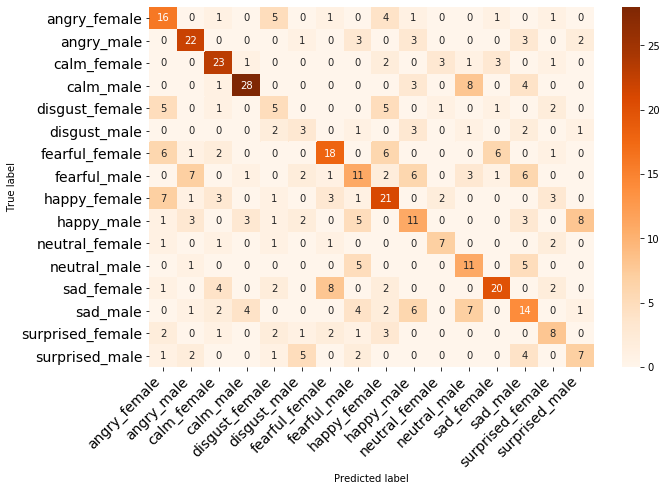

Decision Tree Classifier

Train Stats
                   precision    recall  f1-score   support

    angry_female       0.77      0.82      0.80       154
      angry_male       0.87      0.87      0.87       158
     calm_female       0.84      0.85      0.84       150
       calm_male       0.81      0.74      0.77       148
  disgust_female       0.49      0.67      0.56        76
    disgust_male       0.78      0.69      0.73        83
  fearful_female       0.69      0.67      0.68       144
    fearful_male       0.72      0.67      0.69       152
    happy_female       0.72      0.73      0.72       142
      happy_male       0.67      0.71      0.69       155
  neutral_female       0.78      0.68      0.73        79
    neutral_male       0.66      0.77      0.71        74
      sad_female       0.81      0.75      0.78       145
        sad_male       0.68      0.77      0.73       151
surprised_female       0.68      0.72      0.70        76
  surprised_male       0.85     

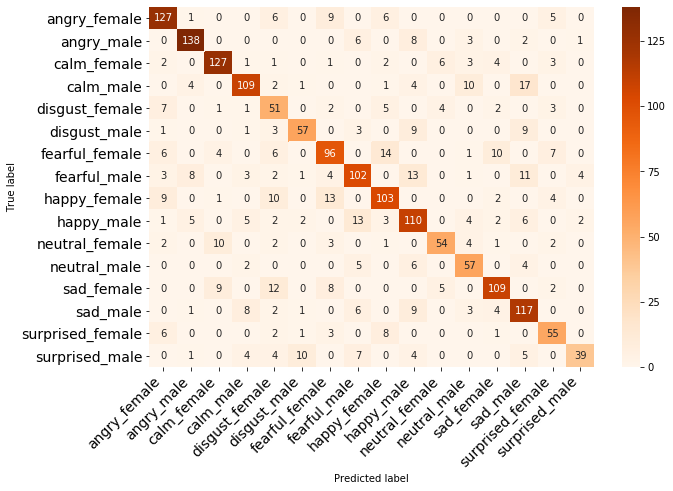

Random Forest Classifier

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.58      0.70      0.64        30
      angry_male       0.69      0.74      0.71        34
     calm_female       0.71      0.88      0.79        34
       calm_male       0.74      0.95      0.83        44
  disgust_female       0.67      0.70      0.68        20
    disgust_male       0.41      0.69      0.51        13
  fearful_female       0.68      0.62      0.65        40
    fearful_male       0.46      0.45      0.46        40
    happy_female       0.83      0.57      0.68        42
      happy_male       0.71      0.68      0.69        37
  neutral_female       0.85      0.85      0.85        13
    neutral_male       0.88      0.68      0.77        22
      sad_female       0.64      0.64      0.64        39
        sad_male       0.62      0.44      0.51        41
surprised_female       0.60      0.75      0.67        20
  surprised_male       0.79      

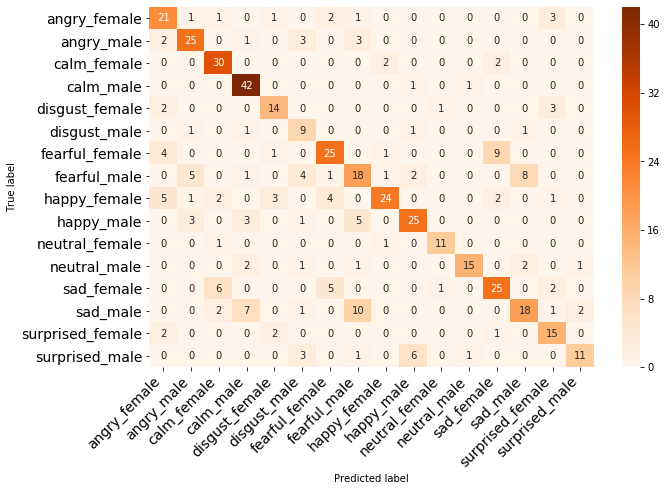

Random Forest Classifier

Train Stats
                   precision    recall  f1-score   support

    angry_female       0.99      1.00      0.99       154
      angry_male       1.00      1.00      1.00       158
     calm_female       1.00      1.00      1.00       150
       calm_male       0.99      1.00      1.00       148
  disgust_female       1.00      0.99      0.99        76
    disgust_male       1.00      0.99      0.99        83
  fearful_female       1.00      0.99      1.00       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      0.99      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       0.99      1.00      1.00       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male       1.00     

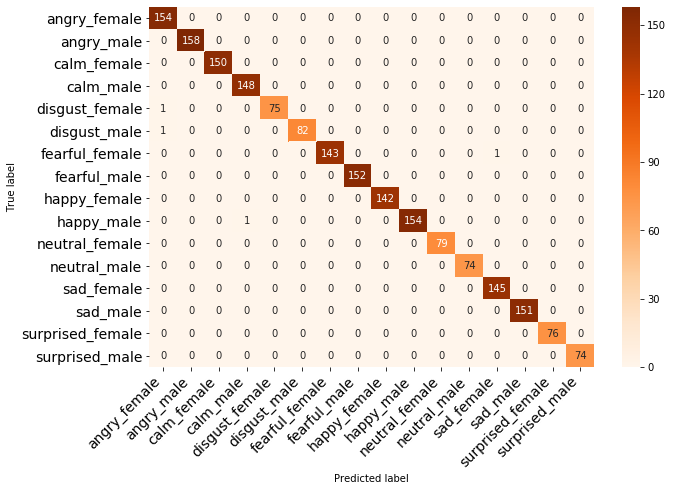

LGBM Classifier

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.67      0.73      0.70        30
      angry_male       0.76      0.82      0.79        34
     calm_female       0.83      0.88      0.86        34
       calm_male       0.71      0.82      0.76        44
  disgust_female       0.70      0.70      0.70        20
    disgust_male       0.40      0.62      0.48        13
  fearful_female       0.63      0.68      0.65        40
    fearful_male       0.65      0.55      0.59        40
    happy_female       0.78      0.60      0.68        42
      happy_male       0.73      0.65      0.69        37
  neutral_female       0.73      0.85      0.79        13
    neutral_male       0.85      0.77      0.81        22
      sad_female       0.79      0.69      0.74        39
        sad_male       0.63      0.63      0.63        41
surprised_female       0.68      0.85      0.76        20
  surprised_male       0.76      0.59     

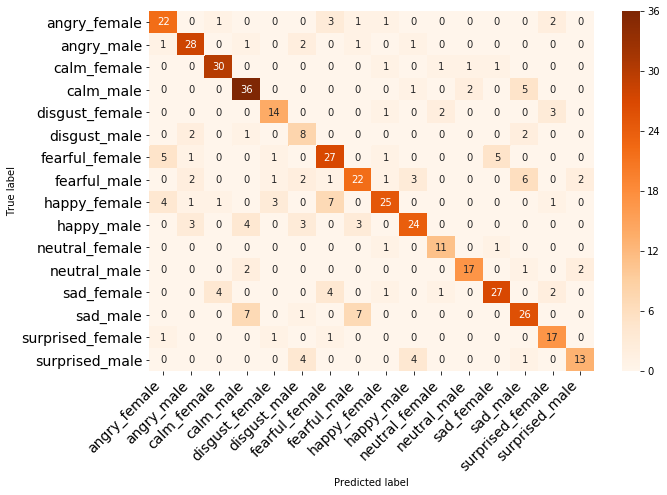

LGBM Classifier

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00       154
      angry_male       1.00      1.00      1.00       158
     calm_female       1.00      1.00      1.00       150
       calm_male       1.00      1.00      1.00       148
  disgust_female       1.00      1.00      1.00        76
    disgust_male       1.00      1.00      1.00        83
  fearful_female       1.00      1.00      1.00       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      1.00      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       1.00      1.00      1.00       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male       1.00      1.00    

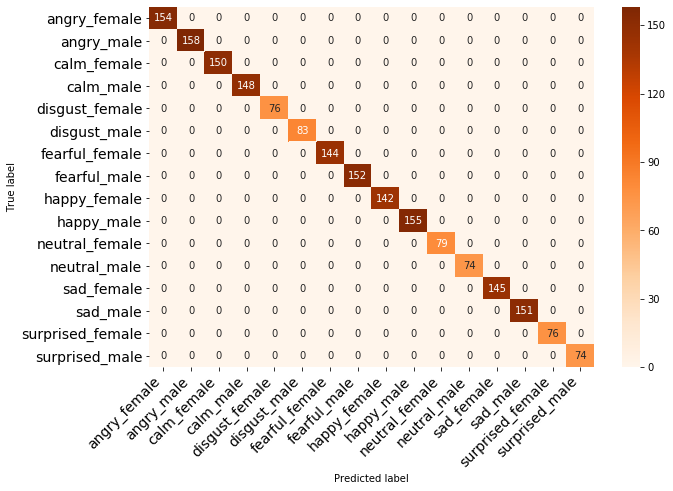

XGB Classifier

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.64      0.77      0.70        30
      angry_male       0.78      0.85      0.82        34
     calm_female       0.77      0.88      0.82        34
       calm_male       0.77      0.91      0.83        44
  disgust_female       0.72      0.65      0.68        20
    disgust_male       0.53      0.69      0.60        13
  fearful_female       0.69      0.62      0.66        40
    fearful_male       0.71      0.60      0.65        40
    happy_female       0.79      0.74      0.77        42
      happy_male       0.78      0.76      0.77        37
  neutral_female       0.77      0.77      0.77        13
    neutral_male       0.89      0.73      0.80        22
      sad_female       0.79      0.67      0.72        39
        sad_male       0.68      0.68      0.68        41
surprised_female       0.54      0.70      0.61        20
  surprised_male       0.81      0.59      

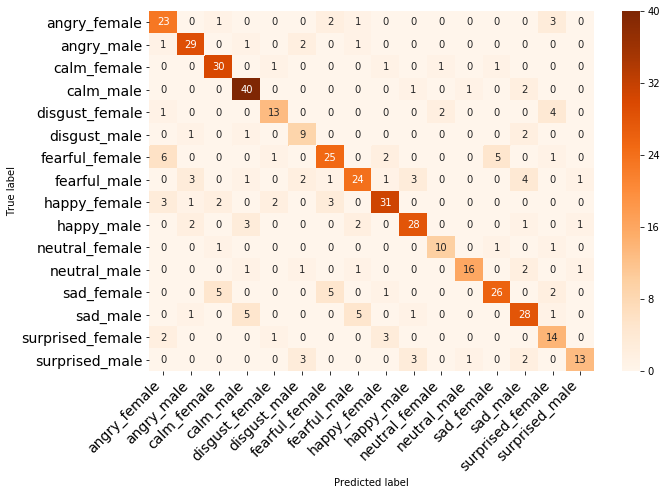

XGB Classifier

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00       154
      angry_male       1.00      1.00      1.00       158
     calm_female       1.00      1.00      1.00       150
       calm_male       1.00      1.00      1.00       148
  disgust_female       1.00      1.00      1.00        76
    disgust_male       1.00      1.00      1.00        83
  fearful_female       1.00      1.00      1.00       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      1.00      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       1.00      1.00      1.00       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male       1.00      1.00     

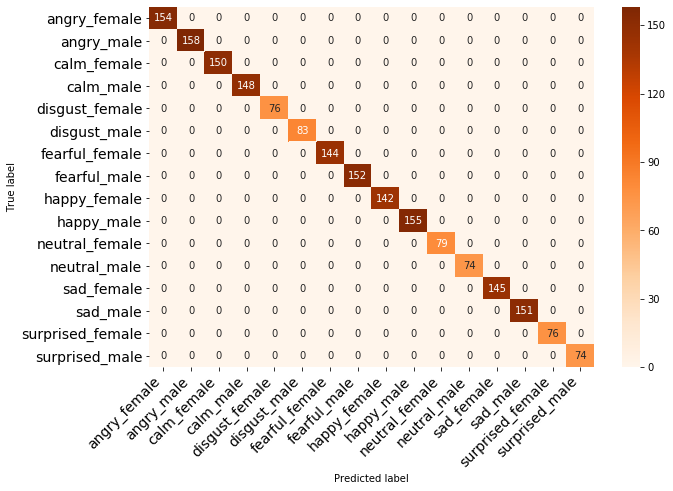

MLP Classifier

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.86      0.80      0.83        30
      angry_male       0.91      0.91      0.91        34
     calm_female       0.82      0.91      0.86        34
       calm_male       0.89      0.89      0.89        44
  disgust_female       0.88      0.70      0.78        20
    disgust_male       0.69      0.85      0.76        13
  fearful_female       0.76      0.80      0.78        40
    fearful_male       0.80      0.90      0.85        40
    happy_female       0.85      0.83      0.84        42
      happy_male       0.81      0.78      0.79        37
  neutral_female       0.71      0.92      0.80        13
    neutral_male       0.82      0.82      0.82        22
      sad_female       0.80      0.62      0.70        39
        sad_male       0.88      0.85      0.86        41
surprised_female       0.75      0.90      0.82        20
  surprised_male       0.94      0.77      

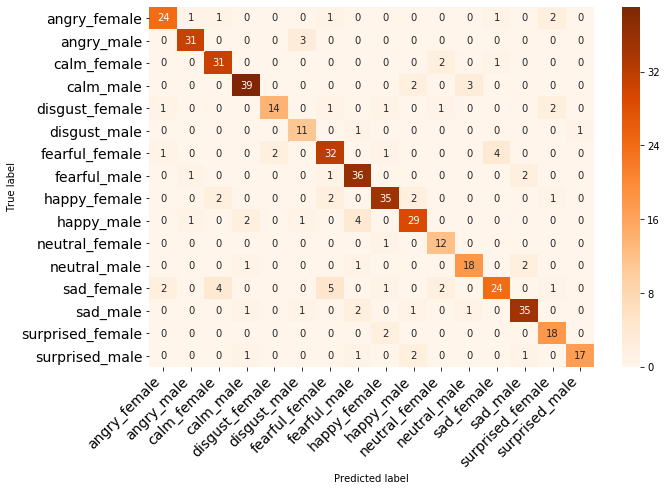

MLP Classifier

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00       154
      angry_male       1.00      1.00      1.00       158
     calm_female       1.00      1.00      1.00       150
       calm_male       1.00      1.00      1.00       148
  disgust_female       1.00      1.00      1.00        76
    disgust_male       1.00      1.00      1.00        83
  fearful_female       1.00      1.00      1.00       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      1.00      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       1.00      1.00      1.00       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male       1.00      1.00     

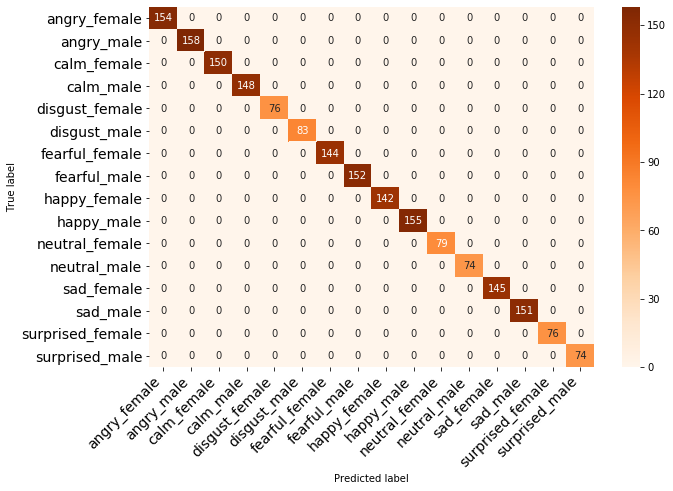

K-Nearest Neighbors

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.70      0.53      0.60        30
      angry_male       0.78      0.53      0.63        34
     calm_female       0.62      0.94      0.74        34
       calm_male       0.66      0.66      0.66        44
  disgust_female       0.47      0.35      0.40        20
    disgust_male       0.52      0.85      0.65        13
  fearful_female       0.49      0.42      0.45        40
    fearful_male       0.48      0.50      0.49        40
    happy_female       0.71      0.48      0.57        42
      happy_male       0.57      0.46      0.51        37
  neutral_female       0.73      0.62      0.67        13
    neutral_male       0.58      0.68      0.62        22
      sad_female       0.43      0.31      0.36        39
        sad_male       0.55      0.51      0.53        41
surprised_female       0.31      0.75      0.44        20
  surprised_male       0.52      0.64 

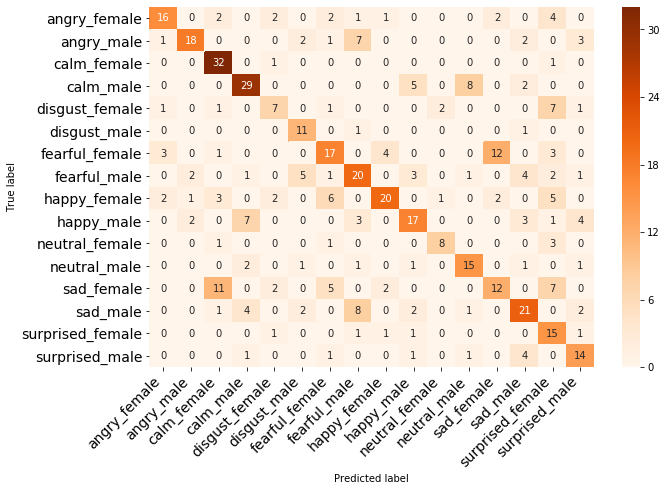

K-Nearest Neighbors

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00       154
      angry_male       1.00      1.00      1.00       158
     calm_female       1.00      1.00      1.00       150
       calm_male       1.00      1.00      1.00       148
  disgust_female       1.00      1.00      1.00        76
    disgust_male       1.00      1.00      1.00        83
  fearful_female       1.00      1.00      1.00       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      1.00      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       1.00      1.00      1.00       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male       1.00      1.00

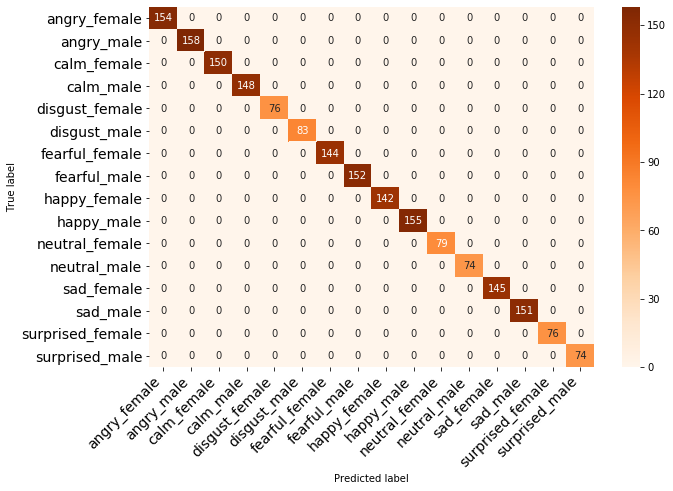

Logistic Regression

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.78      0.70      0.74        30
      angry_male       0.80      0.82      0.81        34
     calm_female       0.66      0.79      0.72        34
       calm_male       0.77      0.82      0.79        44
  disgust_female       0.67      0.50      0.57        20
    disgust_male       0.42      0.62      0.50        13
  fearful_female       0.61      0.50      0.55        40
    fearful_male       0.74      0.57      0.65        40
    happy_female       0.68      0.81      0.74        42
      happy_male       0.67      0.70      0.68        37
  neutral_female       0.71      0.77      0.74        13
    neutral_male       0.73      0.86      0.79        22
      sad_female       0.58      0.49      0.53        39
        sad_male       0.66      0.61      0.63        41
surprised_female       0.48      0.55      0.51        20
  surprised_male       0.75      0.68 

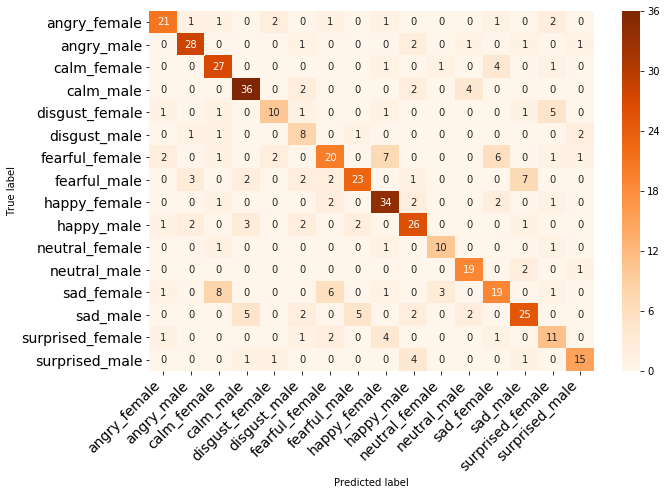

Logistic Regression

Train Stats
                   precision    recall  f1-score   support

    angry_female       0.96      0.92      0.94       154
      angry_male       0.92      0.93      0.92       158
     calm_female       0.81      0.89      0.85       150
       calm_male       0.74      0.86      0.80       148
  disgust_female       0.69      0.75      0.72        76
    disgust_male       0.79      0.73      0.76        83
  fearful_female       0.89      0.78      0.83       144
    fearful_male       0.83      0.78      0.80       152
    happy_female       0.91      0.89      0.90       142
      happy_male       0.81      0.75      0.78       155
  neutral_female       0.85      0.77      0.81        79
    neutral_male       0.80      0.72      0.76        74
      sad_female       0.74      0.80      0.77       145
        sad_male       0.70      0.75      0.72       151
surprised_female       0.77      0.79      0.78        76
  surprised_male       0.79      0.73

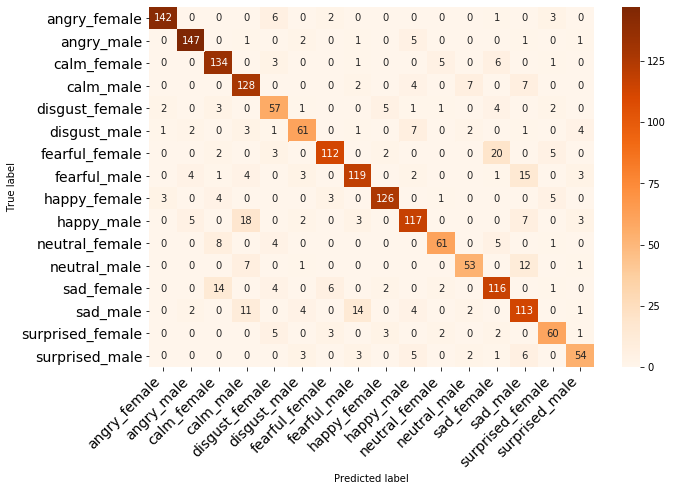

Voting Classifier: MLP, LGB

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.83      0.80      0.81        30
      angry_male       0.89      0.91      0.90        34
     calm_female       0.82      0.91      0.86        34
       calm_male       0.85      0.93      0.89        44
  disgust_female       0.94      0.75      0.83        20
    disgust_male       0.73      0.85      0.79        13
  fearful_female       0.78      0.80      0.79        40
    fearful_male       0.82      0.82      0.82        40
    happy_female       0.87      0.79      0.82        42
      happy_male       0.81      0.78      0.79        37
  neutral_female       0.71      0.92      0.80        13
    neutral_male       0.82      0.82      0.82        22
      sad_female       0.81      0.67      0.73        39
        sad_male       0.85      0.83      0.84        41
surprised_female       0.68      0.85      0.76        20
  surprised_male       0.84   

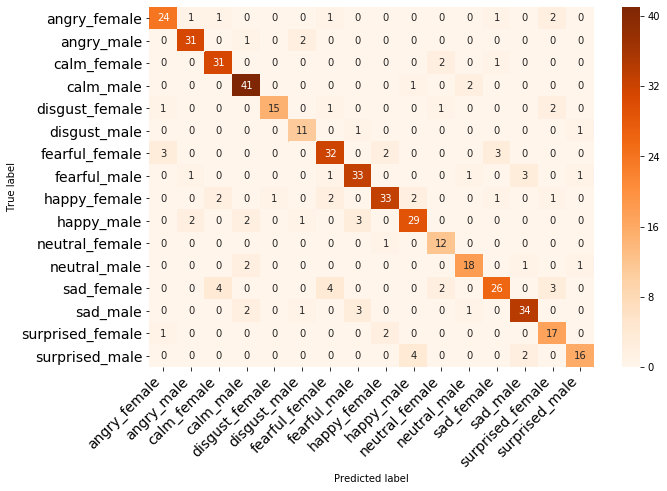

Voting Classifier: MLP, LGB

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00       154
      angry_male       1.00      1.00      1.00       158
     calm_female       1.00      1.00      1.00       150
       calm_male       1.00      1.00      1.00       148
  disgust_female       1.00      1.00      1.00        76
    disgust_male       1.00      1.00      1.00        83
  fearful_female       1.00      1.00      1.00       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      1.00      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       1.00      1.00      1.00       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male       1.00  

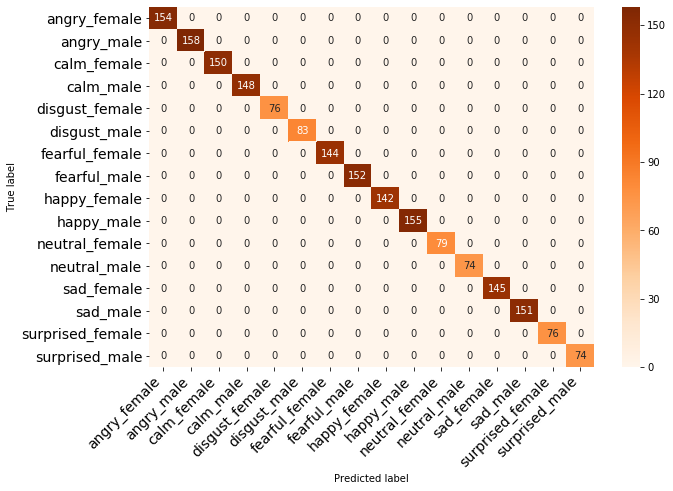

Voting Classifier 2: KNN, XGB, MLP

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.92      0.80      0.86        30
      angry_male       0.91      0.88      0.90        34
     calm_female       0.78      0.94      0.85        34
       calm_male       0.91      0.93      0.92        44
  disgust_female       0.94      0.80      0.86        20
    disgust_male       0.65      0.85      0.73        13
  fearful_female       0.76      0.85      0.80        40
    fearful_male       0.79      0.82      0.80        40
    happy_female       0.87      0.81      0.84        42
      happy_male       0.81      0.78      0.79        37
  neutral_female       0.73      0.85      0.79        13
    neutral_male       0.83      0.86      0.84        22
      sad_female       0.89      0.64      0.75        39
        sad_male       0.90      0.85      0.88        41
surprised_female       0.69      0.90      0.78        20
  surprised_male       

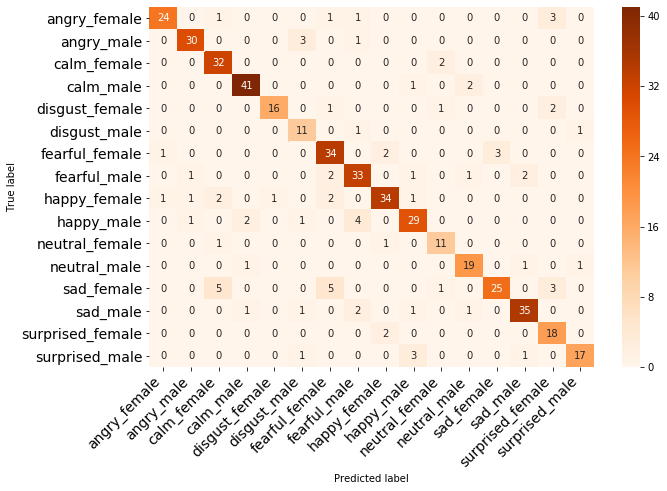

Voting Classifier 2: KNN, XGB, MLP

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00       154
      angry_male       1.00      1.00      1.00       158
     calm_female       1.00      1.00      1.00       150
       calm_male       1.00      1.00      1.00       148
  disgust_female       1.00      1.00      1.00        76
    disgust_male       1.00      1.00      1.00        83
  fearful_female       1.00      1.00      1.00       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      1.00      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       1.00      1.00      1.00       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male      

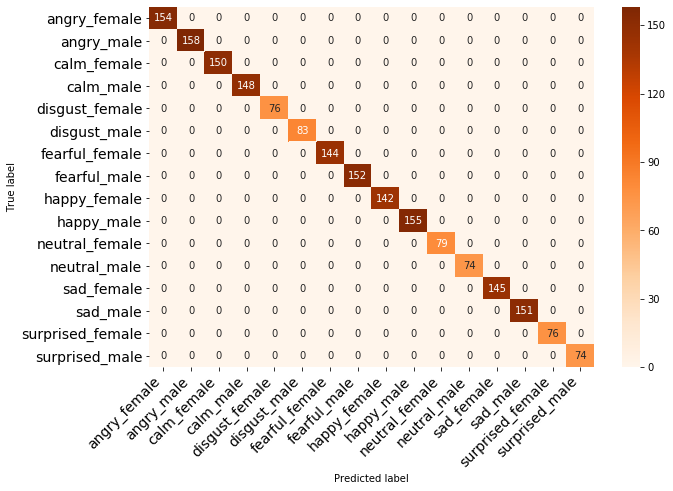

Voting Classifier 3: XGB, MLP, RF, LR

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.96      0.80      0.87        30
      angry_male       0.91      0.88      0.90        34
     calm_female       0.78      0.91      0.84        34
       calm_male       0.80      0.93      0.86        44
  disgust_female       1.00      0.80      0.89        20
    disgust_male       0.65      0.85      0.73        13
  fearful_female       0.73      0.80      0.76        40
    fearful_male       0.82      0.78      0.79        40
    happy_female       0.86      0.86      0.86        42
      happy_male       0.78      0.78      0.78        37
  neutral_female       0.73      0.85      0.79        13
    neutral_male       0.83      0.86      0.84        22
      sad_female       0.84      0.67      0.74        39
        sad_male       0.86      0.76      0.81        41
surprised_female       0.75      0.90      0.82        20
  surprised_male    

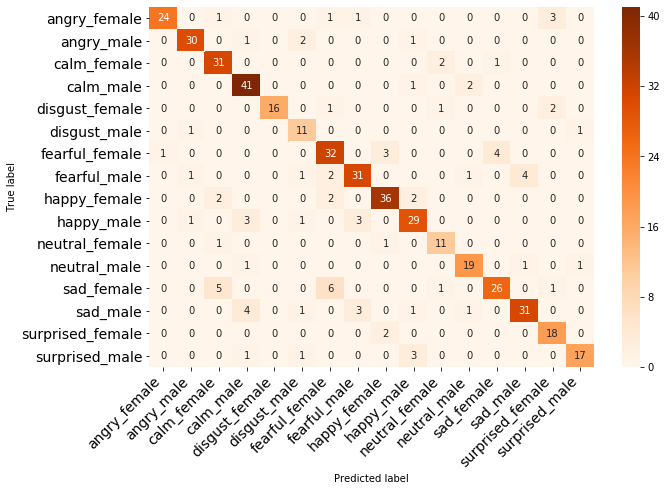

Voting Classifier 3: XGB, MLP, RF, LR

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00       154
      angry_male       1.00      1.00      1.00       158
     calm_female       1.00      1.00      1.00       150
       calm_male       1.00      1.00      1.00       148
  disgust_female       1.00      1.00      1.00        76
    disgust_male       1.00      1.00      1.00        83
  fearful_female       1.00      1.00      1.00       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      1.00      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       1.00      1.00      1.00       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male   

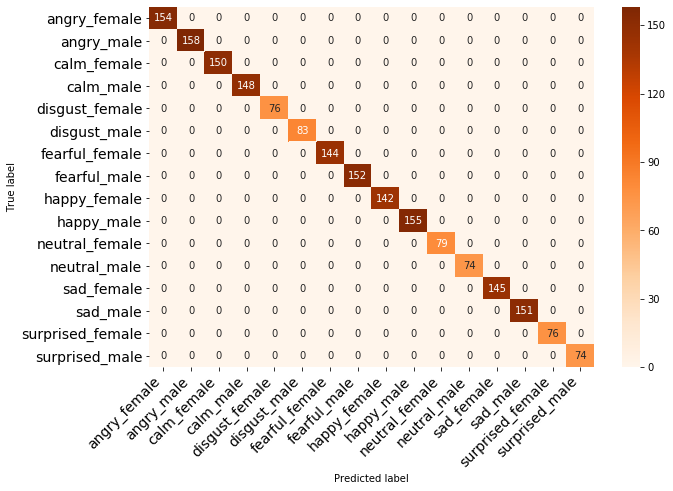

Voting Classifier 4: MLP, XGB

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.88      0.77      0.82        30
      angry_male       0.91      0.88      0.90        34
     calm_female       0.84      0.91      0.87        34
       calm_male       0.89      0.93      0.91        44
  disgust_female       1.00      0.80      0.89        20
    disgust_male       0.69      0.85      0.76        13
  fearful_female       0.77      0.82      0.80        40
    fearful_male       0.81      0.85      0.83        40
    happy_female       0.88      0.88      0.88        42
      happy_male       0.78      0.78      0.78        37
  neutral_female       0.75      0.92      0.83        13
    neutral_male       0.78      0.82      0.80        22
      sad_female       0.87      0.69      0.77        39
        sad_male       0.90      0.85      0.88        41
surprised_female       0.72      0.90      0.80        20
  surprised_male       0.89 

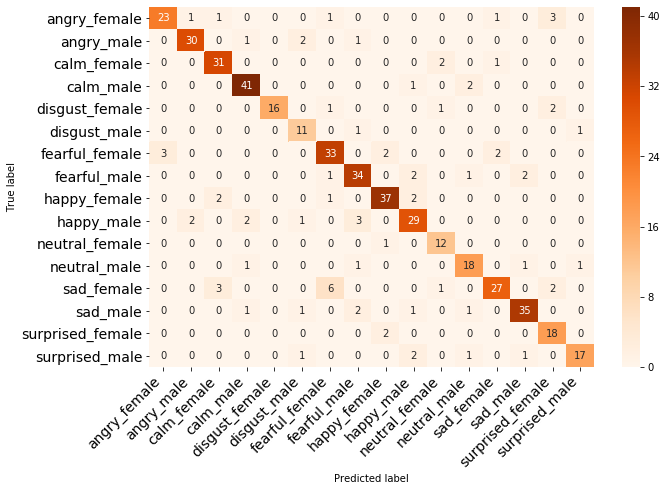

Voting Classifier 4: MLP, XGB

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00       154
      angry_male       1.00      1.00      1.00       158
     calm_female       1.00      1.00      1.00       150
       calm_male       1.00      1.00      1.00       148
  disgust_female       1.00      1.00      1.00        76
    disgust_male       1.00      1.00      1.00        83
  fearful_female       1.00      1.00      1.00       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      1.00      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       1.00      1.00      1.00       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male       1.00

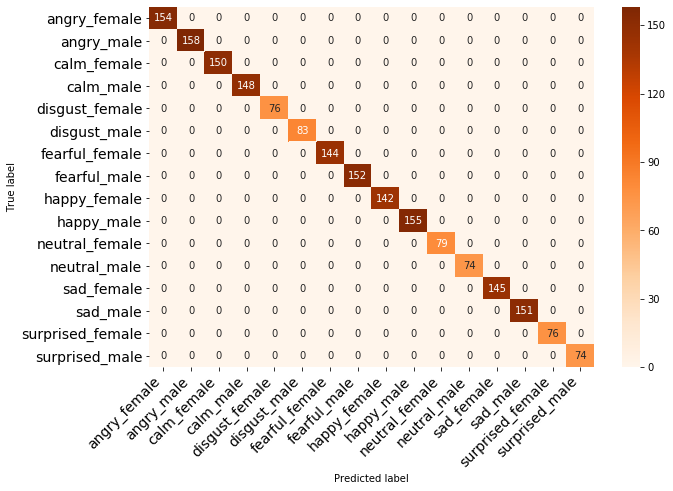

In [44]:
for key in models.keys():
    model(key, inc_train=True)

### Write Data to csv Files

In [106]:
for file, name in zip([X_train, X_test, y_train, y_test],['X_train.csv', 'X_test.csv', 'y_train.csv', 'y_test.csv']):
    pd.DataFrame(file).to_csv(name, index=False)

# Hyperparameter Tuning with Optuna

#### The hyperparameter tuning below will cause the notebook to run for a very long time

### LGBM

In [11]:
def objective_lgb(trial): 

    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 150),
        'max_depth': trial.suggest_int('max_depth', 2, 100),
        'n_estimators': trial.suggest_int('n_estimators', 10, 20000),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 100000, 500000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 500),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 100),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.0, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-0),
        'boosting_type': trial.suggest_categorical('boosting_type', ['goss','gbdt','dart']),
        'objective': 'multiclass',
        'verbose': -1,
        'random_state':22,
        }
   
    model = lgb.LGBMClassifier(**params, nthread = 4, n_jobs = -1) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [12]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_lgb, n_trials=12) 

[I 2019-12-09 19:01:31,662] Finished trial#0 resulted in value: 0.24823068687578215. Current best value is 0.24823068687578215 with parameters: {'num_leaves': 47, 'max_depth': 91, 'n_estimators': 15222, 'subsample_for_bin': 391531, 'min_data_in_leaf': 101, 'reg_alpha': 34.62531796464432, 'colsample_bytree': 0.11693047452078464, 'learning_rate': 0.0001076479894199791, 'boosting_type': 'goss'}.
[I 2019-12-09 19:01:54,762] Finished trial#1 resulted in value: 0.28446870881600334. Current best value is 0.28446870881600334 with parameters: {'num_leaves': 63, 'max_depth': 21, 'n_estimators': 2035, 'subsample_for_bin': 181670, 'min_data_in_leaf': 405, 'reg_alpha': 23.614004587839098, 'colsample_bytree': 0.4306604773641368, 'learning_rate': 0.006471670295909165, 'boosting_type': 'goss'}.
[I 2019-12-09 19:06:50,058] Finished trial#2 resulted in value: 0.1229872003302301. Current best value is 0.28446870881600334 with parameters: {'num_leaves': 63, 'max_depth': 21, 'n_estimators': 2035, 'subsampl

### Random Forest

In [15]:
def objective_rf(trial):
    
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 5, 25),
        'n_estimators': trial.suggest_int('n_estimators', 15000, 25000),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 25),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 50, 250),
        }
   
    model = RandomForestClassifier(**params, random_state = 22) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [16]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=5) 

[I 2019-12-09 23:37:16,771] Finished trial#0 resulted in value: 0.639350657957607. Current best value is 0.639350657957607 with parameters: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 22984, 'min_samples_leaf': 3, 'min_samples_split': 9, 'max_leaf_nodes': 239}.
[I 2019-12-09 23:55:21,042] Finished trial#1 resulted in value: 0.5878845155755167. Current best value is 0.639350657957607 with parameters: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 22984, 'min_samples_leaf': 3, 'min_samples_split': 9, 'max_leaf_nodes': 239}.
[I 2019-12-10 00:14:04,860] Finished trial#2 resulted in value: 0.5848581591530659. Current best value is 0.639350657957607 with parameters: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 22984, 'min_samples_leaf': 3, 'min_samples_split': 9, 'max_leaf_nodes': 239}.
[I 2019-12-10 00:33:13,872] Finished trial#3 resulted in value: 0.603693276475819. Current best value is 0.639350657957607 with parameters: {'criterion': 'entropy', 'max_

### XGBoost

In [17]:
def objective_xgb(trial):

    param = {
        'silent': 1,
        'objective': 'multi:softmax',
        'num_class': 16,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }

    if param['booster'] == 'gbtree' or param['booster'] == 'dart':
        param['max_depth'] = trial.suggest_int('max_depth', 1, 9)
        param['eta'] = trial.suggest_loguniform('eta', 1e-8, 1.0)
        param['gamma'] = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    if param['booster'] == 'dart':
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
  
    model = xgb.XGBClassifier() 
    
    model.set_params(**param)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [18]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=10) 

[I 2019-12-10 00:56:15,005] Finished trial#0 resulted in value: 0.3865588473377734. Current best value is 0.3865588473377734 with parameters: {'booster': 'gblinear', 'lambda': 0.01231681767811515, 'alpha': 0.11283251952850536}.
[I 2019-12-10 00:56:27,191] Finished trial#1 resulted in value: 0.3865588473377734. Current best value is 0.3865588473377734 with parameters: {'booster': 'gblinear', 'lambda': 0.01231681767811515, 'alpha': 0.11283251952850536}.
[I 2019-12-10 00:56:39,371] Finished trial#2 resulted in value: 0.3865588473377734. Current best value is 0.3865588473377734 with parameters: {'booster': 'gblinear', 'lambda': 0.01231681767811515, 'alpha': 0.11283251952850536}.
[I 2019-12-10 00:57:29,663] Finished trial#3 resulted in value: 0.40068012691664334. Current best value is 0.40068012691664334 with parameters: {'booster': 'dart', 'lambda': 0.03332225966258789, 'alpha': 3.3436767024853954e-05, 'max_depth': 1, 'eta': 4.945695941670302e-07, 'gamma': 0.019584560473222174, 'grow_polic

### MLP 

In [19]:
def objective_mlp(trial):

    params = {
        'activation': trial.suggest_categorical('activation', ['logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
        'hidden_layer_sizes':trial.suggest_int('hidden_layer_sizes', 100, 1500),
        'alpha': trial.suggest_uniform('alpha', 0.001, 0.99),
        'batch_size':trial.suggest_int('batch_size', 150, 300), 
        'learning_rate': trial.suggest_categorical('learning_rate', ['adaptive', 'constant', 'invscaling']),
        'max_iter': 1000
        }
  
    model = MLPClassifier(**params, random_state = 22) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [20]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_mlp, n_trials=15)

[I 2019-12-10 01:11:26,950] Finished trial#0 resulted in value: 0.7537123053533981. Current best value is 0.7537123053533981 with parameters: {'activation': 'tanh', 'solver': 'lbfgs', 'hidden_layer_sizes': 1337, 'alpha': 0.35631182411701473, 'batch_size': 184, 'learning_rate': 'invscaling'}.
[I 2019-12-10 01:21:49,283] Finished trial#1 resulted in value: 0.6990997125437324. Current best value is 0.7537123053533981 with parameters: {'activation': 'tanh', 'solver': 'lbfgs', 'hidden_layer_sizes': 1337, 'alpha': 0.35631182411701473, 'batch_size': 184, 'learning_rate': 'invscaling'}.
[I 2019-12-10 01:25:44,023] Finished trial#2 resulted in value: 0.7417620172229725. Current best value is 0.7537123053533981 with parameters: {'activation': 'tanh', 'solver': 'lbfgs', 'hidden_layer_sizes': 1337, 'alpha': 0.35631182411701473, 'batch_size': 184, 'learning_rate': 'invscaling'}.
[I 2019-12-10 01:43:29,285] Finished trial#3 resulted in value: 0.6563078746122091. Current best value is 0.7537123053533

### KNN

In [21]:
def objective_knn(trial):

    params = { 
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 200),
        }

    model = KNeighborsClassifier(**params) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [22]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_knn, n_trials=10)

[I 2019-12-10 02:26:40,448] Finished trial#0 resulted in value: 0.44674122701630037. Current best value is 0.44674122701630037 with parameters: {'weights': 'uniform', 'n_neighbors': 73}.
[I 2019-12-10 02:26:41,615] Finished trial#1 resulted in value: 0.4095412089472837. Current best value is 0.44674122701630037 with parameters: {'weights': 'uniform', 'n_neighbors': 73}.
[I 2019-12-10 02:26:42,833] Finished trial#2 resulted in value: 0.42940176972856553. Current best value is 0.44674122701630037 with parameters: {'weights': 'uniform', 'n_neighbors': 73}.
[I 2019-12-10 02:26:43,897] Finished trial#3 resulted in value: 0.5238322999993368. Current best value is 0.5238322999993368 with parameters: {'weights': 'distance', 'n_neighbors': 32}.
[I 2019-12-10 02:26:45,061] Finished trial#4 resulted in value: 0.4350089931284725. Current best value is 0.5238322999993368 with parameters: {'weights': 'distance', 'n_neighbors': 32}.
[I 2019-12-10 02:26:46,222] Finished trial#5 resulted in value: 0.41

### Decision Tree

In [23]:
def objective_dt(trial):
    
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 5, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 25),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 50, 250),
        }
    
    model = DecisionTreeClassifier(**params, random_state = 22) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_dt, n_trials=5) 

[I 2019-12-10 02:26:54,554] Finished trial#0 resulted in value: 0.4308598571995953. Current best value is 0.4308598571995953 with parameters: {'criterion': 'entropy', 'max_depth': 35, 'min_samples_leaf': 4, 'min_samples_split': 23, 'max_leaf_nodes': 169}.
[I 2019-12-10 02:26:55,759] Finished trial#1 resulted in value: 0.42062304920454985. Current best value is 0.4308598571995953 with parameters: {'criterion': 'entropy', 'max_depth': 35, 'min_samples_leaf': 4, 'min_samples_split': 23, 'max_leaf_nodes': 169}.
[I 2019-12-10 02:26:57,035] Finished trial#2 resulted in value: 0.4245719704931699. Current best value is 0.4308598571995953 with parameters: {'criterion': 'entropy', 'max_depth': 35, 'min_samples_leaf': 4, 'min_samples_split': 23, 'max_leaf_nodes': 169}.
[I 2019-12-10 02:26:58,192] Finished trial#3 resulted in value: 0.41711251370868424. Current best value is 0.4308598571995953 with parameters: {'criterion': 'entropy', 'max_depth': 35, 'min_samples_leaf': 4, 'min_samples_split': 23

### Logistic Regression

In [25]:
def objective_lr(trial):

    params = { 
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'sag', 'saga', 'lbfgs']),
        'multi_class':'multinomial',
        'max_iter': 5000
        }
    
    model = LogisticRegression(**params, random_state = 22) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [26]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_lr, n_trials=10)

[I 2019-12-10 02:29:33,836] Finished trial#0 resulted in value: 0.6338508104900216. Current best value is 0.6338508104900216 with parameters: {'class_weight': 'balanced', 'solver': 'sag'}.
[I 2019-12-10 02:34:29,615] Finished trial#1 resulted in value: 0.6429514401460905. Current best value is 0.6429514401460905 with parameters: {'class_weight': None, 'solver': 'saga'}.
[I 2019-12-10 02:39:24,105] Finished trial#2 resulted in value: 0.6307984179735147. Current best value is 0.6429514401460905 with parameters: {'class_weight': None, 'solver': 'saga'}.
[I 2019-12-10 02:44:18,853] Finished trial#3 resulted in value: 0.6307984179735147. Current best value is 0.6429514401460905 with parameters: {'class_weight': None, 'solver': 'saga'}.
[I 2019-12-10 02:44:24,294] Finished trial#4 resulted in value: 0.6312435628782558. Current best value is 0.6429514401460905 with parameters: {'class_weight': None, 'solver': 'saga'}.
[I 2019-12-10 02:44:29,570] Finished trial#5 resulted in value: 0.631243562